In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.dates as dates
from dateutil import tz
from mpl_toolkits.axes_grid1 import ImageGrid,make_axes_locatable,host_subplot
from datetime import datetime, timedelta
import sys
import os
# from pyCRMtools.modules import plotmodule as plotmod
# from pyCRMtools.modules import utils as CRMutils
# from pyCRMtools.pycaps import arps_read
# from pyCRMtools.pycaps import pycaps_fields
# from pyCRMtools.pycaps import calvars_radar as pycaps_radar
import pandas as pd
import xarray as xr

%matplotlib inline

In [2]:
# Define dictionaries, keyed by case date (i.e. '060509', '060709', '060909', '033116'), to store parameters related
# to NEXRAD radar data, disdrometer data, and model output, respectively

# Case we are looking at right now. Should only have to change this up here and then execute all the cells below
# to generate the appropriate analysis
casedate = '033116'

# Import the file containing the dictionaries needed to gather the radar and disdrometer data.
sys.path.append('/home/dawson29/Projects/pyPIPS/configs/')

from PERiLS_IOP1_2022 import *

In [3]:
PIPS_dir = PIPS_IO_dict['PIPS_dir']
PIPS_filename = PIPS_IO_dict['PIPS_filenames_nc'][0]
PIPS_path = os.path.join(PIPS_dir, PIPS_filename)

PIPS_ds = xr.load_dataset(PIPS_path)
PIPS_ds

<xarray.Dataset>
Dimensions:                    (time: 690, fallspeed_bin: 32, diameter_bin: 32, fields_KGWX: 10)
Coordinates:
  * time                       (time) datetime64[ns] 2022-03-22T19:42:02 ... ...
    fallspeed                  (fallspeed_bin) float64 0.05 0.15 ... 17.6 20.8
    diameter                   (diameter_bin) float64 0.0625 0.1875 ... 24.5
    min_diameter               (diameter_bin) float64 0.0 0.125 ... 20.0 23.0
    max_diameter               (diameter_bin) float64 0.125 0.25 ... 23.0 26.0
    min_fallspeeds             (fallspeed_bin) float64 0.0 0.1 0.2 ... 16.0 19.2
    max_fallspeeds             (fallspeed_bin) float64 0.1 0.2 0.3 ... 19.2 22.4
    flagged_times              (time) int64 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
  * fields_KGWX                (fields_KGWX) object 'REF' ... 'RHO_filtered'
Dimensions without coordinates: fallspeed_bin, diameter_bin
Data variables: (12/56)
    precipintensity            (time) float64 0.0 0.0 0.0 ... 11.37 7.42 9.757
    precipaccum                (time) float64 0.0 0.0 0.0 ... 36.96 36.98 37.01
    parsivel_dBZ               (time) float64 -9.999 -9.999 ... 38.22 38.8
    sample_interval            (time) timedelta64[ns] 00:00:09 ... 00:00:10
    signal_amplitude           (time) float64 1.969e+04 1.967e+04 ... 1.12e+04
    pcount                     (time) int64 0 0 0 0 0 0 0 ... 77 91 90 91 71 88
    ...                         ...
    reflectivity_derived_roqc  (time) float64 -inf -inf -inf ... 40.2 38.22 38.8
    D0_roqc                    (time) float64 nan nan nan ... 0.001956 0.001783
    Dm43_roqc                  (time) float64 nan nan nan ... 0.001878 0.001768
    sigma_roqc                 (time) float64 nan nan ... 0.0007083 0.0006117
    KGWX_at_PIPS               (time, fields_KGWX) float64 19.32 ... 0.9983
    KGWX_beam_height_at_PIPS   (time) float64 1.156e+03 1.148e+03 ... 1.139e+03
Attributes: (12/16)
    nominal sample interval:  10 seconds
    probe_name:               PIPS1A
    parsivel_angle:           -45.0
    deployment_name:          IOP1_032222
    location:                 (33.18483260974434, -88.56716220453451, 74.1998...
    starting_time:            20220322194202
    ...                       ...
    marginQC:                 1
    rainfallQC:               0
    rainonlyQC:               1
    hailonlyQC:               0
    graupelonlyQC:            0
    basicQC:                  0

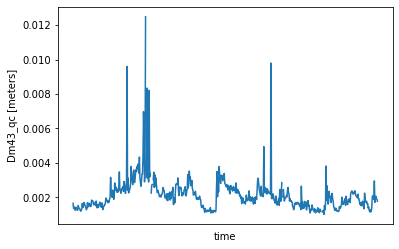

In [5]:
PIPS_ds['Dm43_qc'].plot()

In [4]:
diameter_bin_centers = PIPS_ds['diameter'].values
print(diameter_bin_centers)
PSD_datetimes = PIPS_ds['time'].values
print(PSD_datetimes)
ND_roqc = PIPS_ds['ND_roqc'].values
print(ND_roqc)

[ 0.0625  0.1875  0.3125  0.4375  0.5625  0.6875  0.8125  0.9375  1.0625
  1.1875  1.375   1.625   1.875   2.125   2.375   2.75    3.25    3.75
  4.25    4.75    5.5     6.5     7.5     8.5     9.5    11.     13.
 15.     17.     19.     21.5    24.5   ]
['2022-03-22T19:42:02.000000000' '2022-03-22T19:42:12.000000000'
 '2022-03-22T19:42:22.000000000' '2022-03-22T19:42:32.000000000'
 '2022-03-22T19:42:42.000000000' '2022-03-22T19:42:52.000000000'
 '2022-03-22T19:43:02.000000000' '2022-03-22T19:43:12.000000000'
 '2022-03-22T19:43:22.000000000' '2022-03-22T19:43:32.000000000'
 '2022-03-22T19:43:42.000000000' '2022-03-22T19:43:52.000000000'
 '2022-03-22T19:44:02.000000000' '2022-03-22T19:44:12.000000000'
 '2022-03-22T19:44:22.000000000' '2022-03-22T19:44:32.000000000'
 '2022-03-22T19:44:42.000000000' '2022-03-22T19:44:52.000000000'
 '2022-03-22T19:45:02.000000000' '2022-03-22T19:45:12.000000000'
 '2022-03-22T19:45:22.000000000' '2022-03-22T19:45:32.000000000'
 '2022-03-22T19:45:42.00000000

In [ ]:
import pytz
# pd.plotting.deregister_matplotlib_converters()

PSD_datetimes_Index = pd.to_datetime(PSD_datetimes)
print(PSD_datetimes_Index[0])
PSD_datetimes2 = PSD_datetimes_Index.tz_localize('UTC')
print(PSD_datetimes2[0])
PSD_datetimes3 = dates.date2num(PSD_datetimes)
print(PSD_datetimes3[0])
PSD_datetimes4 = dates.num2date(PSD_datetimes3, tz=pytz.timezone('UTC'))
print(PSD_datetimes4[0])


In [ ]:
dt1 = PSD_datetimes[0]
print(type(dt1))
print(dt1)
dt2 = dt1.tolist()
print(dt2)
dt3 = dt2.replace(tzinfo=dateutil.tz.gettz('UTC'))
print(dt3)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(PSD_datetimes3)

In [ ]:
import matplotlib.dates as md
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


N = 3531
df = pd.DataFrame()
df['time'] = pd.date_range(start = '2022-05-16 19:59:25.69', end = '2022-05-16 20:24:54.570', periods = N)
df['Power'] = np.random.rand(N)

fig, ax = plt.subplots()

ax.plot(df['time'], df['Power'])

ax.xaxis.set_major_locator(md.MinuteLocator(interval = 1))
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation = 90)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.contourf(PSD_datetimes, diameter_bin_centers, ND_roqc.T)
# ax.xaxis_date()
# x_locator = dates.HourLocator(byhour=range(0, 24, 1))
x_locator = dates.MinuteLocator(byminute=[0, 15, 30, 45])
# x_locator = dates.MinuteLocator(byminute=range(0, 60, 5))
x_formatter = dates.DateFormatter('%Y-%m-%d %H:%M:%S')
y_locator = ticker.MultipleLocator(base=1.0)
ax.xaxis.set_major_locator(x_locator)
ax.xaxis.set_major_formatter(x_formatter)
ax.yaxis.set_major_locator(y_locator)
ax.set_ylim(0., 9.)
# ax.set_xlim(PSD_datetimes[0], PSD_datetimes[-1])
my_xticks = ax.get_xticks()
print(my_xticks)
# my_xticks_biweekly=my_xticks[::2].copy()
# plt.xticks(my_xticks, visible=True, rotation="vertical")

plt.show()
# [t.set_visible(True) for t in ax.get_xticklabels()]
# fig.autofmt_xdate()
print(ax.get_xticks())
print(ax.get_xticklabels())
# print(ax.get_yticks())
# print(ax.get_yticklabels())

# plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

In [ ]:
PIPS_ds['ND_roqc'].plot()

In [ ]:
print(PSD_datetimes[0])
print(type(PSD_datetimes[0]))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook

# Load a numpy record array from yahoo csv data with fields date, open, close,
# volume, adj_close from the mpl-data/example directory. The record array
# stores the date as an np.datetime64 with a day unit ('D') in the date column.
r = (cbook.get_sample_data('goog.npz', np_load=True)['price_data']
     .view(np.recarray))
r = r[-30:]  # get the last 30 days

print(r.date)

dt = r.date[0]
print(type(dt))
print(dt)
print(dt.tolist())


# first we'll do it the default way, with gaps on weekends
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))
ax1.plot(r.date, r.adj_close, 'o-')
ax1.set_title("Default")
fig.autofmt_xdate()


# next we'll write a custom formatter
N = len(r)
ind = np.arange(N)  # the evenly spaced plot indices


def format_date(x, pos=None):
    thisind = np.clip(int(x + 0.5), 0, N - 1)
    return r.date[thisind].item().strftime('%Y-%m-%d')


ax2.plot(ind, r.adj_close, 'o-')
# Use automatic FuncFormatter creation
ax2.xaxis.set_major_formatter(format_date)
ax2.set_title("Custom tick formatter")
fig.autofmt_xdate()

plt.show()

print(ax1.get_xticklabels())

In [ ]:
el_req = 0.5
firstsweepindex = (np.abs(target_elevs - el_req)).argmin()
el_actual = target_elevs[firstsweepindex]
print(firstsweepindex, el_actual)
sweep_indices = [i for i, x in enumerate(target_elevs) if x == el_actual]
print(sweep_indices)
print(radar_obj.sweep_start_ray_index['data'][sweep_indices])


In [ ]:
print(radar_obj.instrument_parameters)
print(radar_obj2.instrument_parameters)

In [ ]:
radar_sweep_start_indices = radar_obj.sweep_start_ray_index['data']
radar2_sweep_start_indices = radar_obj2.sweep_start_ray_index['data']

print(radar_obj.sweep_start_ray_index)
sweep_numbers = radar_obj.sweep_number['data']
print(sweep_numbers)
sweep_times = []
sweep_times_sec = []
for i, sweep_num in enumerate(sweep_numbers):
    sweep_time_sec = int(radar_obj.time['data'][radar_sweep_start_indices[i]])
    sweep_times_sec.append(sweep_time_sec)
    sweep_time = pyart.graph.common.generate_radar_time_sweep(radar_obj, i)
    sweep_times.append(sweep_time)
print(sweep_times)
print(sweep_times_sec)

print(radar_obj2.sweep_start_ray_index)
sweep_numbers2 = radar_obj2.sweep_number['data']
print(sweep_numbers2)
sweep_times2 = []
sweep_times_sec2 = []
for i, sweep_num in enumerate(sweep_numbers2):
    sweep_time_sec2 = int(radar_obj2.time['data'][radar2_sweep_start_indices[i]])
    sweep_times_sec2.append(sweep_time_sec2)
    sweep_time = pyart.graph.common.generate_radar_time_sweep(radar_obj2, i)
    sweep_times2.append(sweep_time)
print(sweep_times2)
print(sweep_times_sec2)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(sweep_times_sec, [490000.] * len(sweep_times_sec), 'b*')
ax.plot(sweep_times_sec2, [500000.] * len(sweep_times_sec2), 'ro')
ax.plot(times, radar_obj.instrument_parameters['unambiguous_range']['data'])
ax.plot(times2, radar_obj2.instrument_parameters['unambiguous_range']['data'])

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(sweep_times_sec, [40.] * len(sweep_times_sec), 'b*')
ax.plot(sweep_times_sec2, [41.] * len(sweep_times_sec2), 'ro')
ax.plot(times, radar_obj.instrument_parameters['nyquist_velocity']['data'])
ax.plot(times2, radar_obj2.instrument_parameters['nyquist_velocity']['data'])

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(sweep_times_sec, [21.] * len(sweep_times_sec), 'b*')
ax.plot(sweep_times_sec2, [21.5] * len(sweep_times_sec2), 'ro')
elevs = radar_obj.elevation['data']
elevs2 = radar_obj2.elevation['data']
ax.plot(times, elevs, label='pyART')
ax.plot(times2, elevs2, label='RadxConvert')
ax.legend(loc='best')

In [ ]:
sweep_numbers = radar_obj.sweep_number['data']
sweep_list = []
for i, sweep_num in enumerate(sweep_numbers):
    sweep = radar_obj.extract_sweeps([i])
    sweep_list.append(sweep)
    
sweep_numbers2 = radar_obj2.sweep_number['data']
sweep_list2 = []
for i, sweep_num in enumerate(sweep_numbers2):
    sweep = radar_obj2.extract_sweeps([i])
    sweep_list2.append(sweep)

In [ ]:
field = 'reflectivity'
levels = np.linspace(0., 60., num=13)
for i, sweep_num in enumerate(sweep_numbers):
    fig, ax = plt.subplots(figsize=(10, 10))
    data = sweep_list[i].fields[field]['data']
    azimuth = sweep_list[i].azimuth['data']
    grange = sweep_list[i].range['data']
    ax.set_title('Time: {}, elev: {:.2f}'.format(sweep_times[i].strftime('%Y-%m-%d %H:%M:%S'), target_elevs[i]))
    ax.contourf(azimuth, grange, data.T, levels=levels)

In [ ]:
field = 'REF'
levels = np.linspace(0., 60., num=13)
for i, sweep_num in enumerate(sweep_numbers2):
    fig, ax = plt.subplots(figsize=(10, 10))
    data = sweep_list2[i].fields[field]['data']
    azimuth = sweep_list2[i].azimuth['data']
    grange = sweep_list2[i].range['data']
    ax.set_title('Time: {}, elev: {:.2f}'.format(sweep_times2[i].strftime('%Y-%m-%d %H:%M:%S'), target_elevs2[i]))
    ax.contourf(azimuth, grange, data.T, levels=levels)

In [ ]:
# Read in the PIPS data for the first probe for testing
dis_dict = init_dis_dict[casedate]
dirname = dis_dict['dis_dir']
filename = dis_dict['disfilenames'][0]
filepath = os.path.join(dirname, filename)
print("Reading file: {}".format(filepath))
conv_df, parsivel_df, vd_matrix_da = pipsio.read_PIPS(filepath)

In [ ]:
# Read sweep files
radar_name = init_radar_dict[casedate]['radname']
radar_dir = init_radar_dict[casedate]['radardir']
starttime = init_radar_dict[casedate]['radstarttimestamp']
stoptime = init_radar_dict[casedate]['radstoptimestamp']
field_names = init_radar_dict[casedate]['fieldnames']
el_req = init_radar_dict[casedate]['el_req']

radar_dict = radar.read_sweeps(radar_name, radar_dir, starttime, stoptime, field_names=field_names, 
                               el_req=el_req, compute_kdp=False)

In [ ]:
print(radar_obj.info())

In [ ]:
GPS_stats = conv_df['GPS_status']
GPS_lats = conv_df['GPS_lat']
GPS_lons = conv_df['GPS_lon']
GPS_alts = conv_df['GPS_alt']
PIPS_lat, PIPS_lon, PIPS_alt = pipsio.get_PIPS_loc(GPS_stats, GPS_lats, GPS_lons, GPS_alts)

In [ ]:
PIPS_geo_loc = (PIPS_lat, PIPS_lon)
PIPS_rad_loc = radar.get_PIPS_loc_relative_to_radar(PIPS_geo_loc, radar_obj)

In [ ]:
print(PIPS_rad_loc)

In [ ]:
radar_fields_at_PIPS_da = radar.interp_sweeps_to_PIPS(radar_name, radar_dict['radarsweeplist'], ['PIPS1A'], [PIPS_rad_loc],
                                                      average_gates=True)

In [ ]:
import pyart
radar_obj = radar_dict['radarsweeplist'][2]
xrad, yrad, zrad = radar_obj.get_gate_x_y_z(0)
distance = np.sqrt((PIPS_rad_loc[0] - xrad)**2. + (PIPS_rad_loc[1] - yrad)**2.)
theta_index, range_index = np.unravel_index(distance.argmin(), distance.shape)

print(theta_index, range_index)

display = pyart.graph.RadarDisplay(radar_obj)
fig = plt.figure(figsize=(6, 5))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
display.plot('ZDR', 0, title='NEXRAD Differential Reflectivity',
             vmin=0, vmax=5, colorbar_label='', ax=ax)
display.plot_range_ring(radar_obj.range['data'][-1]/1000., ax=ax)
display.set_limits(xlim=(-250, 250), ylim=(-250, 250))
display.set_limits(xlim=(50, 70), ylim=(120, 140), ax=ax)
ax.plot(PIPS_rad_loc[0]/1000., PIPS_rad_loc[1]/1000., 'r*')
ax.plot(xrad[theta_index, range_index]/1000., yrad[theta_index, range_index]/1000., 'rx')
#ax.contourf(xrad / 1000., yrad / 1000., distance)
#ax.text(PIPS_rad_loc[0] / 1000. - 5., PIPS_rad_loc[1] / 1000., 'PIPS1A', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
plt.show()

In [ ]:
print(radar_fields_at_PIPS_da)

In [ ]:
print(radar_fields_at_PIPS_da.sel(PIPS='PIPS1A', fields='REF'))
radar_fields_at_PIPS_da.sel(PIPS='PIPS1A', fields='REF').plot()

In [ ]:
# Test dumping to netCDF file
ncfile_dir = './'
ncfile_name = '{}_{}_{}_fields_at_PIPS.nc'.format(radar_name, starttime, stoptime)
ncfile_path = os.path.join(ncfile_dir, ncfile_name)
radar.dump_radar_fields_at_PIPS_nc(ncfile_path, radar_fields_at_PIPS_da)

In [ ]:
# Now test loading it back in
radar_fields_at_PIPS_ds = xr.open_dataset(ncfile_path)
print(radar_fields_at_PIPS_ds)

In [ ]:
radar_fields_at_PIPS_da_2 = radar_fields_at_PIPS_ds['radar_fields_at_PIPS']
print(radar_fields_at_PIPS_da_2)

In [ ]:
print(radar_fields_at_PIPS_da)

In [ ]:
print(radar_fields_at_PIPS_da_2['PIPS_x'])

In [ ]:
print(radar_fields_at_PIPS_da.fields)

In [ ]:
'RHO' in radar_fields_at_PIPS_da.fields

In [ ]:
radar_fields_at_PIPS_da.sel(PIPS='PIPS1A', fields='RHO').size

In [ ]:
pd.to_datetime(radar_fields_at_PIPS_da['time'].values).to_pydatetime()